# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.

## Column Description
| Variable Name | Description
| :------------ | :----------
| CUST_ID | Unique customer identifier
| ACCOUNT_TENURE | Account tenure in months based on last day of reporting month
| ACCT_CNT_SERVICES | Total number of services under an account
| AGE | Age of the account holder (derived on dob)
| CFU | Customer facing unit derived based on owning cost centre
| SERVICE_TENURE | Service tenure in months
| PLAN_ACCESS_FEE | Monthly access fee payable for the plan excluding GST
| BYO_PLAN_STATUS | Whether the customer is on a BYO (bring your own) plan
| PLAN_TENURE | Plan tenure in months
| MONTHS_OF_CONTRACT_REMAINING | Contract tenure remaining based on months of contract completed
| LAST_FX_CONTRACT_DURATION | Last known fixed contract term
| CONTRACT_STATUS | Based on current contract, the service is either on 'no-contract', 'on-contract' or 'off-contract'
| PREV_CONTRACT_DURATION | Previous contract term
| HANDSET_USED_BRAND | Used equipment brand
| CHURN_IND | Service churn flagging for disconnected service in reporting month
| MONTHLY_SPEND | Service spend for reporting month
| COUNTRY_METRO_REGION | Country or metro customer classification
| STATE | State location of registered service
| RECON_SMS_NEXT_MTH | Recontracted after SMS contact in the following month
| RECON_TELE_NEXT_MTH | Recontracted after personal telephone contact in the following month
| RECON_EMAIL_NEXT_MTH | Recontracted after email contact in the following month

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
churn = pd.read_csv('files/MobileCustomerChurn.csv', na_values=['NA', '#VALUE!'], index_col='INDEX')
churn = churn.drop(['CUST_ID', 'RECON_SMS_NEXT_MTH', 'RECON_TELE_NEXT_MTH', 'RECON_EMAIL_NEXT_MTH'], axis=1)
churn.head()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE
INDEX,,,,,,,,,,,,,,,,,
1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,24,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA
2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,24,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW
3,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,12,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA
4,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,24,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC
5,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,24,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW


# Exploratory Data Analysis

## Overview

After dropping the `RECON` columns, I explore the structure and summaries of the remaining columns. There are a few things that immediately stand out:

* There are missing `AGE` and `STATE` values
* The minimum `AGE` is -4
* The maximum `AGE` is 116
* The minimum `PLAN_ACCESS_FEE` is \\$8.18 while the minimum monthly spend is \\$1.02

In [3]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46206 entries, 1 to 46206
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ACCOUNT_TENURE                46206 non-null  int64  
 1   ACCT_CNT_SERVICES             46206 non-null  int64  
 2   AGE                           46130 non-null  float64
 3   CFU                           46206 non-null  object 
 4   SERVICE_TENURE                46206 non-null  int64  
 5   PLAN_ACCESS_FEE               46206 non-null  float64
 6   BYO_PLAN_STATUS               46206 non-null  object 
 7   PLAN_TENURE                   46206 non-null  int64  
 8   MONTHS_OF_CONTRACT_REMAINING  46206 non-null  int64  
 9   LAST_FX_CONTRACT_DURATION     46206 non-null  int64  
 10  CONTRACT_STATUS               46206 non-null  object 
 11  PREV_CONTRACT_DURATION        46206 non-null  int64  
 12  HANDSET_USED_BRAND            46206 non-null  object 
 13  C

In [4]:
churn.describe()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND
count,46206.000000,46206.000000,46130.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000
mean,45.874627,1.555707,41.411836,50.318617,51.364858,10.846708,8.237112,20.349825,15.249968,0.385015,75.188029
std,33.077927,0.835529,15.263726,51.925537,20.855419,9.769887,8.341476,8.034631,10.982958,0.486604,73.519041
min,0.000000,1.000000,-4.000000,0.000000,8.180000,0.000000,0.000000,0.000000,0.000000,0.000000,1.020000
25%,14.000000,1.000000,28.000000,11.000000,36.360000,3.000000,0.000000,24.000000,0.000000,0.000000,36.360000
50%,44.000000,1.000000,40.000000,35.000000,54.540000,8.000000,7.000000,24.000000,24.000000,0.000000,54.540000
75%,77.000000,2.000000,52.000000,69.000000,72.720000,16.000000,16.000000,24.000000,24.000000,1.000000,84.530000
max,120.000000,4.000000,116.000000,259.000000,234.540000,147.000000,24.000000,36.000000,36.000000,1.000000,1965.890000


## Recoding Categorical Variables

The following variables are the categorical variables that need recoding:

| Binary Variables | Multi-factored Variables
| :--------------- | :-----------------------
| CFU | CONTRACT_STATUS
| BYO_PLAN_STATUS | HANDSET_USED_BRAND
| COUNTRY_METRO_REGION | STATE
| | PREV_CONTRACT_DURATION
| | LAST_FX_CONTRACT_DURATION
| | ACCT_CNT_SERVICES

* I recode the binary categorical variables as `0` or `1`.
* For categorical variables with more than two levels, I apply **dummy encoding**.

In [5]:
cat_var = ['CFU', 'BYO_PLAN_STATUS', 'COUNTRY_METRO_REGION',
           'CONTRACT_STATUS', 'HANDSET_USED_BRAND', 'STATE',
           'PREV_CONTRACT_DURATION', 'LAST_FX_CONTRACT_DURATION',
           'ACCT_CNT_SERVICES']
values = []
for var in cat_var:
    churn[var] = churn[var].astype('category')
    values.append(dict(enumerate(churn[var].cat.categories)))
cat_col_values = pd.DataFrame({'Categories':cat_var, 'Values':values})
cat_col_values = cat_col_values.style.set_properties(**{'text-align': 'left'})
cat_col_values.set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])])

,Categories,Values
0,CFU,"{0: 'CONSUMER', 1: 'SMALL BUSINESS'}"
1,BYO_PLAN_STATUS,"{0: 'BYO', 1: 'NON BYO'}"
2,COUNTRY_METRO_REGION,"{0: 'COUNTRY', 1: 'METRO'}"
3,CONTRACT_STATUS,"{0: 'NO-CONTRACT', 1: 'OFF-CONTRACT', 2: 'ON-CONTRACT'}"
4,HANDSET_USED_BRAND,"{0: 'APPLE', 1: 'GOOGLE', 2: 'HUAWEI', 3: 'OTHER', 4: 'SAMSUNG', 5: 'UNKNOWN'}"
5,STATE,"{0: 'ACT', 1: 'NSW', 2: 'NT', 3: 'QLD', 4: 'SA', 5: 'TAS', 6: 'VIC', 7: 'WA'}"
6,PREV_CONTRACT_DURATION,"{0: 0, 1: 12, 2: 24, 3: 36}"
7,LAST_FX_CONTRACT_DURATION,"{0: 0, 1: 12, 2: 24, 3: 36}"
8,ACCT_CNT_SERVICES,"{0: 1, 1: 2, 2: 3, 3: 4}"


In [6]:
# Recoding the binary variables
binary_var = ['CFU', 'BYO_PLAN_STATUS', 'COUNTRY_METRO_REGION']
for var in binary_var:
    churn[f'{var}_code'] = churn[var].cat.codes

# Recoding the non-binary variables
multi_var = list(set(cat_var) - set(binary_var))
churn_recode = pd.get_dummies(churn, drop_first=True, columns=multi_var)

In [7]:
churn_recode.head()

,ACCOUNT_TENURE,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,CHURN_IND,MONTHLY_SPEND,...,LAST_FX_CONTRACT_DURATION_12,LAST_FX_CONTRACT_DURATION_24,LAST_FX_CONTRACT_DURATION_36,HANDSET_USED_BRAND_GOOGLE,HANDSET_USED_BRAND_HUAWEI,HANDSET_USED_BRAND_OTHER,HANDSET_USED_BRAND_SAMSUNG,HANDSET_USED_BRAND_UNKNOWN,CONTRACT_STATUS_OFF-CONTRACT,CONTRACT_STATUS_ON-CONTRACT
INDEX,,,,,,,,,,,,,,,,,,,,,
1,46,30.0,CONSUMER,46,54.54,NON BYO,15,0,1,61.40,...,0,1,0,0,0,0,1,0,1,0
2,60,55.0,CONSUMER,59,54.54,NON BYO,5,0,1,54.54,...,0,1,0,0,0,0,0,0,1,0
3,65,29.0,CONSUMER,65,40.90,BYO,15,0,1,2.50,...,1,0,0,0,0,0,0,0,1,0
4,31,51.0,CONSUMER,31,31.81,NON BYO,31,0,1,6.48,...,0,1,0,0,0,0,0,0,1,0
5,95,31.0,CONSUMER,95,54.54,NON BYO,0,0,1,100.22,...,0,1,0,0,0,0,0,0,1,0


## Distributions

### Numerical

Looking at the **correlations** is key to avoid possible multicollinearity issues when modelling. The only variable(s) with high correlation that needs to be considered is `ACCOUNT_TENURE` and `SERVICE_TENURE`.

In [8]:
cor = churn.corr()
cor.style.apply(lambda x: ['background:#E98EAE ' if (abs(v) > 0.7) and (abs(v) < 1.0) else '' for v in x], axis = 1)

,ACCOUNT_TENURE,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,CHURN_IND,MONTHLY_SPEND,CFU_code,BYO_PLAN_STATUS_code,COUNTRY_METRO_REGION_code
ACCOUNT_TENURE,1.000000,0.250492,0.791784,-0.085160,0.247583,-0.170644,-0.151654,-0.137805,0.215387,0.124802,0.028972
AGE,0.250492,1.000000,0.251711,-0.347069,0.053575,-0.185477,-0.115258,-0.209331,0.111628,-0.107028,0.030122
SERVICE_TENURE,0.791784,0.251711,1.000000,-0.078520,0.218260,-0.143886,-0.153512,-0.115622,0.174927,0.124302,0.034434
PLAN_ACCESS_FEE,-0.085160,-0.347069,-0.078520,1.000000,-0.058190,0.470779,-0.036587,0.448051,0.061247,0.398496,-0.043388
PLAN_TENURE,0.247583,0.053575,0.218260,-0.058190,1.000000,-0.429791,0.141586,-0.058206,0.075512,0.131309,-0.024353
MONTHS_OF_CONTRACT_REMAINING,-0.170644,-0.185477,-0.143886,0.470779,-0.429791,1.000000,-0.247269,0.302084,-0.034367,0.505817,-0.022744
CHURN_IND,-0.151654,-0.115258,-0.153512,-0.036587,0.141586,-0.247269,1.000000,0.187608,-0.045574,-0.074089,-0.068399
MONTHLY_SPEND,-0.137805,-0.209331,-0.115622,0.448051,-0.058206,0.302084,0.187608,1.000000,-0.003152,0.236228,-0.045808
CFU_code,0.215387,0.111628,0.174927,0.061247,0.075512,-0.034367,-0.045574,-0.003152,1.000000,0.057119,0.035822
BYO_PLAN_STATUS_code,0.124802,-0.107028,0.124302,0.398496,0.131309,0.505817,-0.074089,0.236228,0.057119,1.000000,-0.060643


### Categorical

By plotting the categorical variables side-by-side with whether they churn or not, we can observe which variables might have strong predictive power. The relative height between the 'blue' and 'orange' bars indicates the proportion of customers that will churn with that particular factor. And the differences in height across factors in each category can indicate the category is a good predictor of whether the customer churns.

There are some clear observations including:
* Between consumers and small businesses, consumers have a relatively high churn rate
* Between BYO and non BYO, BYO customers have a very high churn rate
* `CONTRACT_STATUS`, `HANDSET_USED_BRAND` and `ACCT_CNT_SERVICES` appear to be strong predictors

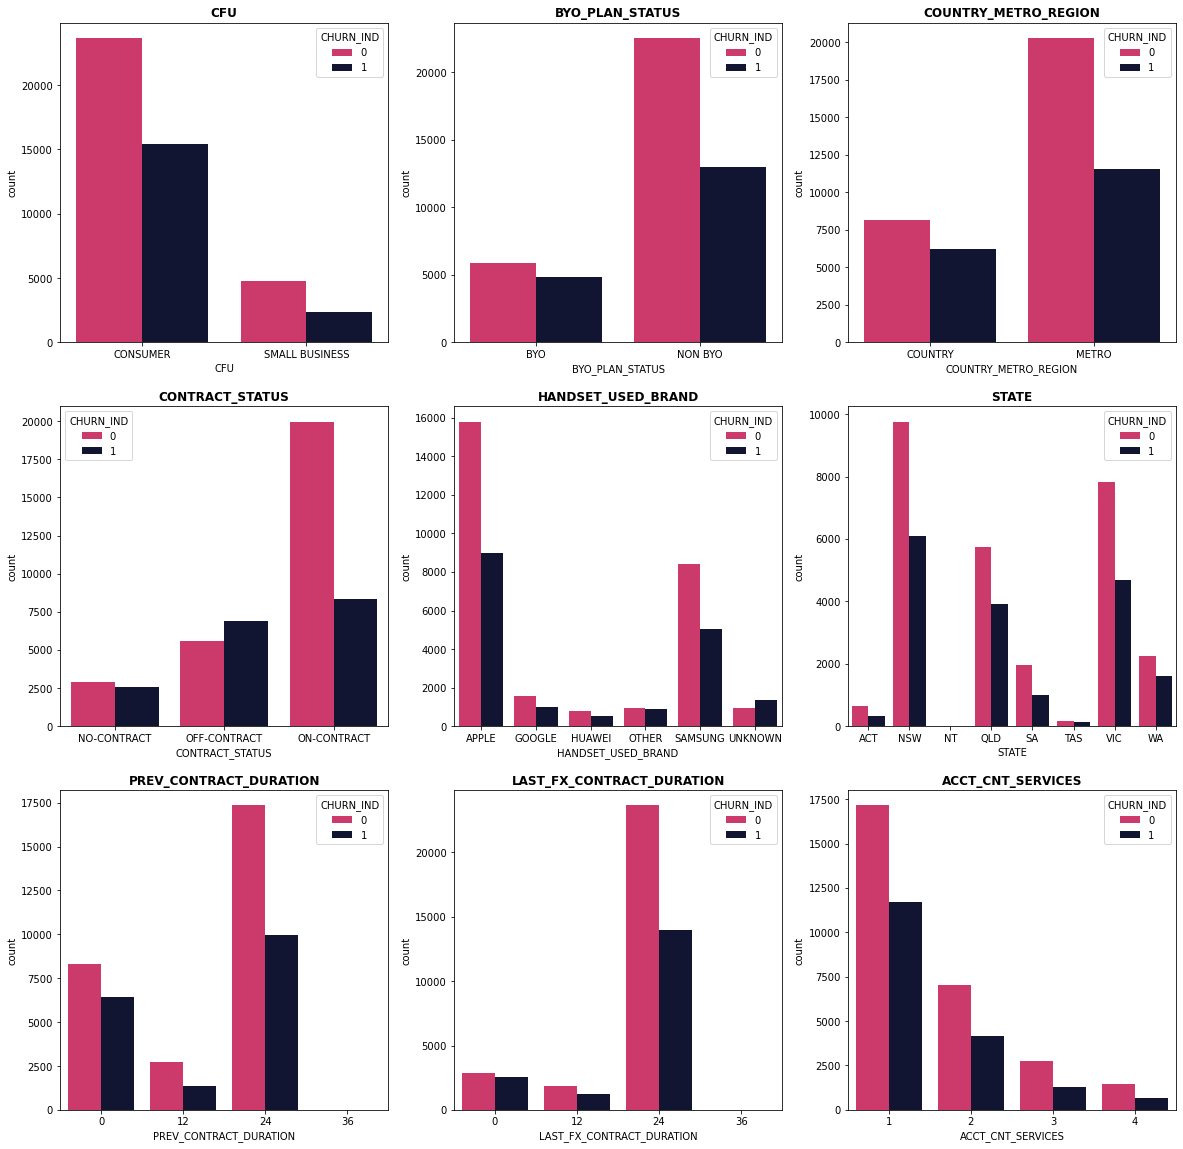

In [9]:
fig, ax = plt.subplots(3, 3, figsize=(20,20))
idx = 0
for r in range(3):
    for c in range(3):
        var = cat_var[idx]
        ax[r][c].set_title(var, fontsize=12, fontweight='bold')
        sns.countplot(x=var, hue='CHURN_IND', data=churn, ax=ax[r][c], palette=['#e52165', '#0d1137'])
        idx += 1
plt.show()

## Outliers

* There are two records with an `AGE` value of -4 which is unrealistic. I convert these values into `None` and linear impute them in the next step.
* While the number of clients aged over 100 may appear odd, it is very reasonable especially since most are small businesses. In addition, there are 59 entries aged over 100. Thus, these were left as is.
* Looking at the distributions, I noted there were two particular records that required further investigating. On closer inspection, they belonged to two fairly young consumers with a monthly spend in excess of \\$1,500 despite only having one connected service each. Without any further information available, I assumed these must be entry-errors and ultimately determined these as outliers and removed them from the dataset.

In [10]:
under_0 = churn_recode[churn_recode['AGE'] <= 0][churn_recode.columns[:6]]
print(under_0.shape)
display(under_0)

# Set these ages as None for linear imputation
for idx in under_0.index:
    churn_recode.iloc[idx, churn_recode.columns.get_loc('AGE')] = None

(2, 6)


,ACCOUNT_TENURE,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS
INDEX,,,,,,
39239,51,-4.0,CONSUMER,51,8.18,NON BYO
42245,58,-4.0,SMALL BUSINESS,58,54.54,NON BYO


In [11]:
over_100 = churn_recode[churn_recode['AGE'] >= 100]
print(over_100.shape)
over_100[churn_recode.columns[:6]].head()

(59, 37)


,ACCOUNT_TENURE,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS
INDEX,,,,,,
745,47,116.0,SMALL BUSINESS,11,27.27,BYO
3118,76,115.0,SMALL BUSINESS,50,54.54,NON BYO
3402,18,116.0,SMALL BUSINESS,16,40.90,BYO
3805,13,116.0,SMALL BUSINESS,13,54.54,NON BYO
3985,99,115.0,CONSUMER,45,54.54,NON BYO


In [12]:
churn_recode[churn_recode['MONTHLY_SPEND']>1500]

,ACCOUNT_TENURE,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,CHURN_IND,MONTHLY_SPEND,...,LAST_FX_CONTRACT_DURATION_12,LAST_FX_CONTRACT_DURATION_24,LAST_FX_CONTRACT_DURATION_36,HANDSET_USED_BRAND_GOOGLE,HANDSET_USED_BRAND_HUAWEI,HANDSET_USED_BRAND_OTHER,HANDSET_USED_BRAND_SAMSUNG,HANDSET_USED_BRAND_UNKNOWN,CONTRACT_STATUS_OFF-CONTRACT,CONTRACT_STATUS_ON-CONTRACT
INDEX,,,,,,,,,,,,,,,,,,,,,
42752,1,41.0,CONSUMER,1,36.36,NON BYO,1,23,0,1613.61,...,0,1,0,0,0,0,1,0,0,1
46073,2,22.0,CONSUMER,2,45.45,BYO,1,0,0,1965.89,...,0,0,0,0,0,0,0,0,0,0


In [13]:
churn_recode = churn_recode[churn_recode['MONTHLY_SPEND']<1500]

## Handling Missing Values

There are 78 missing `AGE` values and 1 missing `COUNTRY_METRO_REGION` / `STATE` value. Given the remainder of the attributes are recorded, I reasonably assumed that the values are missing at random. As such, I **linearly imputed** the missing `AGE` values, and **dropped** the one row with a missing `COUNTRY_METRO_REGION` / `STATE` value.

In [14]:
churn_recode.isna().sum()

ACCOUNT_TENURE                   0
AGE                             78
CFU                              0
SERVICE_TENURE                   0
PLAN_ACCESS_FEE                  0
BYO_PLAN_STATUS                  0
PLAN_TENURE                      0
MONTHS_OF_CONTRACT_REMAINING     0
CHURN_IND                        0
MONTHLY_SPEND                    0
COUNTRY_METRO_REGION             1
CFU_code                         0
BYO_PLAN_STATUS_code             0
COUNTRY_METRO_REGION_code        0
PREV_CONTRACT_DURATION_12        0
PREV_CONTRACT_DURATION_24        0
PREV_CONTRACT_DURATION_36        0
ACCT_CNT_SERVICES_2              0
ACCT_CNT_SERVICES_3              0
ACCT_CNT_SERVICES_4              0
STATE_NSW                        0
STATE_NT                         0
STATE_QLD                        0
STATE_SA                         0
STATE_TAS                        0
STATE_VIC                        0
STATE_WA                         0
LAST_FX_CONTRACT_DURATION_12     0
LAST_FX_CONTRACT_DUR

In [15]:
churn_recode['AGE'].interpolate(method='linear', inplace=True) # Linearly impute age values
churn_recode = churn_recode.dropna() # Drop the remaining null values

## Clean Data

This is a check to see the data has been cleaned.

In [16]:
print(churn_recode.shape)
churn_recode.head()

(46203, 37)


,ACCOUNT_TENURE,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,CHURN_IND,MONTHLY_SPEND,...,LAST_FX_CONTRACT_DURATION_12,LAST_FX_CONTRACT_DURATION_24,LAST_FX_CONTRACT_DURATION_36,HANDSET_USED_BRAND_GOOGLE,HANDSET_USED_BRAND_HUAWEI,HANDSET_USED_BRAND_OTHER,HANDSET_USED_BRAND_SAMSUNG,HANDSET_USED_BRAND_UNKNOWN,CONTRACT_STATUS_OFF-CONTRACT,CONTRACT_STATUS_ON-CONTRACT
INDEX,,,,,,,,,,,,,,,,,,,,,
1,46,30.0,CONSUMER,46,54.54,NON BYO,15,0,1,61.40,...,0,1,0,0,0,0,1,0,1,0
2,60,55.0,CONSUMER,59,54.54,NON BYO,5,0,1,54.54,...,0,1,0,0,0,0,0,0,1,0
3,65,29.0,CONSUMER,65,40.90,BYO,15,0,1,2.50,...,1,0,0,0,0,0,0,0,1,0
4,31,51.0,CONSUMER,31,31.81,NON BYO,31,0,1,6.48,...,0,1,0,0,0,0,0,0,1,0
5,95,31.0,CONSUMER,95,54.54,NON BYO,0,0,1,100.22,...,0,1,0,0,0,0,0,0,1,0


# Modelling

With 36 possible predictor variables, I used `Recursive Feature Elimination` (RFE) to determine the least number of features that had the highest predictive power. To save on computing power yet still obtain the most parsimonious model, I limited the number of features to 20. The most efficient features were:

* BYO_PLAN_STATUS_code
* HANDSET_USED_BRAND_UNKNOWN
* PREV_CONTRACT_DURATION_12
* PREV_CONTRACT_DURATION_24
* CONTRACT_STATUS_OFF-CONTRACT
* CONTRACT_STATUS_ON-CONTRACT

However, as these variables variables have other levels, I also included those other levels as features in my final model. One particular feature, `PREV_CONTRACT_DURATION_36` stood out with a 0 coefficient. Upon closer inspection, this is caused due to the lack of records with only two customers who had a previous contract duration of 36 months.


## Model Selection

In [17]:
%%time
drop_col = ['CHURN_IND'] + binary_var
X = churn_recode.drop(drop_col, axis=1)
y = churn_recode['CHURN_IND']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

model = LogisticRegression(random_state=3, max_iter=1000)

rfe_output = []
for i in range(1, 21):
    selector = RFE(model, n_features_to_select=i, step=1)
    selector = selector.fit(X_train, y_train)
    selected_cols = np.array(X.columns)[selector.support_]
    model.fit(X_train[selected_cols], y_train)
    score = model.score(X_test[selected_cols], y_test)
    rfe_output.append((i, selected_cols, round(score, 5)))

Wall time: 5min 51s


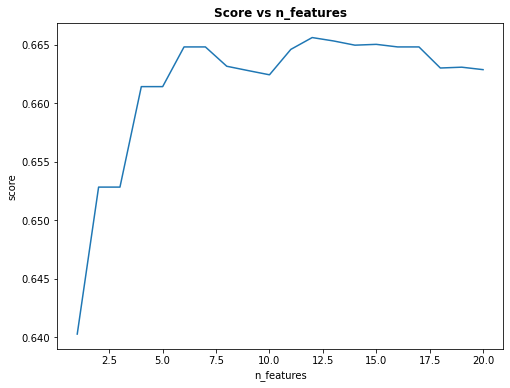

In [18]:
data = list(rfe_output)
rfe_df = pd.DataFrame(data, columns=['n_features', 'selected_features', 'score'])
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(rfe_df['n_features'], rfe_df['score'])
plt.xlabel('n_features')
plt.ylabel('score')
plt.title('Score vs n_features', fontweight='bold')
plt.show()

## Final Model

In [24]:
features = ['BYO_PLAN_STATUS_code', 'HANDSET_USED_BRAND_GOOGLE', 'HANDSET_USED_BRAND_HUAWEI',
            'HANDSET_USED_BRAND_OTHER', 'HANDSET_USED_BRAND_SAMSUNG', 'HANDSET_USED_BRAND_UNKNOWN',
            'PREV_CONTRACT_DURATION_12', 'PREV_CONTRACT_DURATION_24', 'PREV_CONTRACT_DURATION_36',
            'CONTRACT_STATUS_OFF-CONTRACT', 'CONTRACT_STATUS_ON-CONTRACT']
X = churn_recode[features]
y = churn_recode['CHURN_IND']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
model = LogisticRegression(random_state=3, max_iter=1000).fit(X_train, y_train)
print(f'Intercept: {round(model.intercept_[0], 5)}')
pd.DataFrame({'Features':features, 'Coefficient':model.coef_[0]})

Intercept: -0.27895


,Features,Coefficient
0,BYO_PLAN_STATUS_code,0.536182
1,HANDSET_USED_BRAND_GOOGLE,-0.206810
2,HANDSET_USED_BRAND_HUAWEI,0.166474
3,HANDSET_USED_BRAND_OTHER,0.305315
4,HANDSET_USED_BRAND_SAMSUNG,0.074932
5,HANDSET_USED_BRAND_UNKNOWN,0.909953
6,PREV_CONTRACT_DURATION_12,-1.151165
7,PREV_CONTRACT_DURATION_24,-0.770508
8,PREV_CONTRACT_DURATION_36,0.000000
9,CONTRACT_STATUS_OFF-CONTRACT,0.977376


# Evaluation

While including all levels of the RFE-selected features resulted in a slightly lower accuracy, this model remains slightly better than pure chance (i.e. 0.5).

In [20]:
round(model.score(X_test, y_test), 5)

0.6633

# Conclusion

The goal of this analysis was to predict whether a customer would churn. After exploring and preparing the data for analysis, it was split into a training and testing set. A logistic regression model was fit on the training set with these selected features:

* BYO_PLAN_STATUS
* HANDSET_USED_BRAND
* PREV_CONTRACT_DURATION
* CONTRACT_STATUS

During the preliminary data exploration, contract status and handset brand appeared good predictors and this was found out to be true. And with domain knowledge, the other features selected by the `RFE` algorithm are very reasonable.

The model's predictive accuracy scored 66.33% which, being greater than 50%, is **desirable** as it means the model is better than pure chance but **not ideal** with an ideal model having an accuracy score greater than 75%.

# Resources

* [Left-aligning dataframe content](https://www.geeksforgeeks.org/align-columns-to-left-in-pandas-python/)
* [Should binary variables be one-hot encoded](https://stackoverflow.com/questions/43515877/should-binary-features-be-one-hot-encoded)
* [Set value for a particular cell](https://stackoverflow.com/questions/31569384/set-value-for-particular-cell-in-pandas-dataframe-with-iloc/55906315)
* [Filter array with boolean mask](https://stackoverflow.com/questions/19984102/select-elements-of-numpy-array-via-boolean-mask-array)